In [1]:
import pandas as pd
import numpy as np
from math import log,exp,sqrt
from collections import defaultdict
from itertools import product
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.stats import norm
from matplotlib import pyplot as plt
import warnings 
#关于这个warning，因为使用了很多循坏来向dataframe里填入数据，因此新加数据覆盖原有数据时会产生一个复制，并出现warning
warnings.filterwarnings("ignore")
%matplotlib inline

加权BS隐含波动率编制方法参考原文链接：https://github.com/Jensenberg/volatility-and-option （**）

首先来计算加权BS隐含波动率

使用类将求解隐含波动率的过程集合起来

In [2]:
class IV():
    '''定义一个通过Balck-Scholes公式求隐含波动率的类'''    
    Y_days = 365 #一年的总天数，按自然日计算
    
    def __init__(self, S, K, r, T_days, price):
        self.S = S #标的价格
        self.K = K #执行价格
        self.r = r #无风险利率
        self.T = T_days / self.Y_days #到期期限
        self.price = price #期权的交易价格
        
    def bs_value(self, sigma):
        '''
        计算期权的B-S价格
        sigma:
            波动率
        '''
        d1 = (log(self.S / self.K) + (self.r + 0.5 * sigma**2) * self.T)\
             / (sigma * sqrt(self.T))
        d2 = d1 - sigma * sqrt(self.T)
        return self.S * norm.cdf(d1) - self.K * norm.cdf(d2) * exp(-self.r * self.T)
    
    def vega(self, sigma):
        '''
        B-S公式得到的期权价格关于波动率的导数，希腊值vega
        '''
        d1 = (log(self.S / self.K) + (self.r + 0.5 * sigma**2) * self.T)\
             / (sigma * sqrt(self.T))
        return self.S * norm.pdf(d1) * sqrt(self.T)
    
    def newton(self, sigma=0.3, N=50):
        '''
        用牛顿迭代法（Newton-Raphson方法）不断迭代来逼近隐含波动率
        Newton法较稳定，但有时得不到解，尤其是在put价格很小的时候
        N:
            迭代次数
        '''
        for i in range(N):
            sigma -= (self.bs_value(sigma) - self.price) / self.vega(sigma)
        return sigma
    
    def equation(self, sigma):
        '''
        建立一个期权价格与B-S公式得到的理论价格之间的方程
        '''
        return self.bs_value(sigma) - self.price
    
    def solve(self, sigma=0.5):
        '''
        使用scipy.optimize.fsolve求解隐含波动率
        fsovle总能得到解，但有些解有点奇怪，速度比Newton法快一些
        '''
        return fsolve(self.equation, sigma)[0]

导入处理好的etf数据、期权数据和3月shibor数据

In [3]:
a50_option = pd.read_excel('/Users/50ETF期权已处理数据——iVIX用.xlsx')

In [4]:
shibor = pd.read_excel('/Users/SHIBOR-3M.xlsx')

In [5]:
a50_etf = pd.read_excel('/Users/a50etf已处理数据.xlsx' , parse_dates = True)

In [6]:
a50_etf['date'] = pd.to_datetime(a50_etf['date'])

只保留收盘价作为BS公式里的S

In [7]:
a50_etf = a50_etf.loc[:, ['date' , 'close']]

In [8]:
BS_iv =  pd.merge(a50_option , shibor , on = 'date' , how = 'left')

In [9]:
BS_iv = pd.merge(BS_iv , a50_etf , on = 'date' , how = 'left')

In [10]:
BS_iv.set_index(['date' , 'expire'] , inplace = True)

首先计算期权的虚值程度

In [12]:
BS_iv['positive_value'] = np.where(BS_iv['strike'] - BS_iv['close'] > 0 , 
                                   BS_iv['strike'] - BS_iv['close'] , 
                                   BS_iv['strike'])

计算实值程度

In [13]:
BS_iv['negative_value'] = np.where(BS_iv['close'] - BS_iv['strike'] > 0 , 
                                   BS_iv['close'] - BS_iv['strike'] , 
                                   BS_iv['close'])

In [14]:
otm = BS_iv.groupby(level = ['date' , 'expire'])[['positive_value']].min()

In [15]:
otm.rename(columns = {'positive_value' : 'otm'} , inplace = True)

In [16]:
itm = BS_iv.groupby(level = ['date' , 'expire'])[['negative_value']].min()

In [17]:
itm.rename(columns = {'negative_value' : 'itm'} , inplace = True)

In [18]:
otm

otm
date       expire           
2017-01-03 2017-01-25  0.041
           2017-02-22  0.043
           2017-03-22  0.041
           2017-06-28  0.041
2017-01-04 2017-01-25  0.023
...                      ...
2020-12-30 2021-06-23  0.037
2020-12-31 2021-01-27  0.066
           2021-02-24  0.066
           2021-03-24  0.066
           2021-06-23  0.066

[3896 rows x 1 columns]

In [19]:
BS_iv = BS_iv.join(otm)
BS_iv = BS_iv.join(itm)

In [20]:
itm_sp = BS_iv[BS_iv['itm'] == BS_iv['close']]

In [21]:
BS_iv['itm'] = np.where(BS_iv['itm'] == BS_iv['close'] , BS_iv['itm'] + 1 , BS_iv['itm'])

提取最实值虚值程度最低的期权

In [22]:
def option_slice(data , value_tag , time_tag):
    
    if value_tag == 'otm' :
        spread = 'positive_value'
    else :
        spread = 'negative_value'
    
    data_tag = data[(data[spread] == data[value_tag]) 
                    & (data['T_days'] == data[time_tag])]
    data_tag.reset_index(level = 1 , inplace = True)
    
    return data_tag

计算隐含波动率

In [23]:
def get_iv(data , types , method = 'newton'):
    S = data['close']
    K = data['strike']
    r = data['shibor_3M']
    T_days = data['T_days']
    price = data[types]
    iv = IV(S , K , r , T_days , price)
    if method == 'newton':
        return iv.newton()
    else :
        return iv.solve()

In [24]:
IVs = {}

生成一个定位目标期权的标志组成的数组

In [25]:
value_tags = ['otm' , 'itm']
last_tags = ['last1' , 'last2']
tags = list(product(value_tags , last_tags))
tags

[('otm', 'last1'), ('otm', 'last2'), ('itm', 'last1'), ('itm', 'last2')]

In [26]:
for tag in tags:
        vt, lt = tag
        data_tag = option_slice(BS_iv, vt, lt) #提取满足某一实虚值标记，某一次近月标记的数据
        dates = data_tag.index 
        IVs[(vt, lt)] = defaultdict(dict)
        for date in dates:
            data_t = data_tag.loc[date, :]
            method = 'newton' if vt == 'otm' else 'fsolve' #对实值put用fsolve
            IVs[(vt, lt)][date].update({'call': get_iv(data_t, 'call')})
            IVs[(vt, lt)][date].update({'put': get_iv(data_t, 'put', method)})
    

In [27]:
print(pd.DataFrame(IVs['otm', 'last1']).isnull().values.sum() , 
      pd.DataFrame(IVs['otm', 'last2']).isnull().values.sum() ,
      pd.DataFrame(IVs['itm', 'last1']).isnull().values.sum() ,
      pd.DataFrame(IVs['itm', 'last2']).isnull().values.sum())

1 1 17 12


计算期权隐含波动率的平均值

In [28]:
def call_put_mean(tag):
    return pd.DataFrame(IVs[tag]).T.mean(axis = 1)

In [29]:
cp_mean = {}

In [30]:
for tag in tags:
    cp_mean[tag] = call_put_mean(tag)

In [31]:
cp_mean = pd.DataFrame(cp_mean)

In [32]:
cp_mean.isnull().values.sum() #问：为什么会有 NAN？？ 
                              #答：因为计算出的IV就有 NAN (见28行) ， 
                              #可能是牛顿迭代法没有求出解。如果后续出现问题得换个方法求IV

1

计算实值虚值程度的权数

In [33]:
k_spread = {}

In [34]:
for vt in value_tags:
    data_tag = option_slice(BS_iv , vt , 'last1')
    k_spread[vt] = data_tag[vt]

In [35]:
k_spread = pd.DataFrame(k_spread)

In [36]:
k_spread.isnull().values.sum() #这里也有 NAN

1

In [37]:
k_spread['otm_weight'] = k_spread['itm'] / (k_spread['otm'] + k_spread['itm'])
k_spread['itm_weight'] = k_spread['otm'] / (k_spread['otm'] + k_spread['itm'])

以实值虚值程度权数，计算近月远月加权波动率

In [38]:
k_weighted = cp_mean.join(k_spread)

In [39]:
k_weighted['vol_last1'] = k_weighted[('otm', 'last1')] * k_weighted['otm_weight']\
                        + k_weighted[('itm', 'last1')] * k_weighted['itm_weight']

In [40]:
k_weighted['vol_last2'] = k_weighted[('otm', 'last2')] * k_weighted['otm_weight']\
                        + k_weighted[('itm', 'last2')] * k_weighted['itm_weight']   

提取存续期

In [41]:
T_spread = {}

In [42]:
for lt in last_tags:
    data_flag = option_slice(BS_iv , 'otm' , lt)
    T_spread[lt] = data_flag['T_days']

In [43]:
T_spread = pd.DataFrame(T_spread)

In [44]:
T_weighted = k_weighted.join(T_spread)

以存续期加权，计算得到 BS_IV

In [45]:
T_weighted['last1_weight'] = (T_weighted['last2'] - 30)\
                               / (T_weighted['last2'] - T_weighted['last1'])
T_weighted['last2_weight'] = (30 - T_weighted['last1'])\
                               / (T_weighted['last2'] - T_weighted['last1'])
T_weighted['BS_IV'] = T_weighted['vol_last1'] * T_weighted['last1_weight']\
                      + T_weighted['vol_last2'] * T_weighted['last2_weight']

后来想算了，懒得弄了，直接把nan值用插值法替代了

In [46]:
nan_dates = T_weighted[T_weighted['BS_IV'].isnull()].index
for date in nan_dates:
    T_weighted.loc[date, 'BS_IV'] = T_weighted.loc[date, tags].mean()

Text(0.5, 1.0, 'BS-IV')

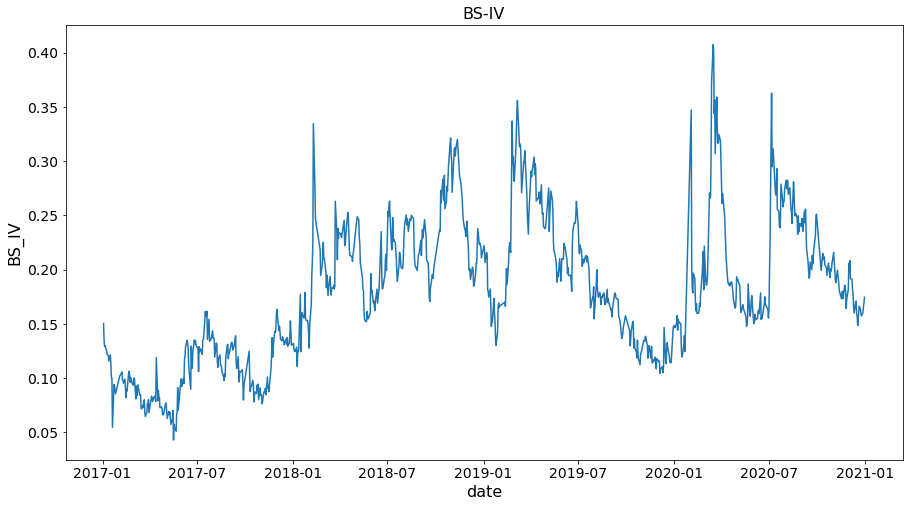

In [47]:
plt.figure(figsize=(15, 8))
plt.plot(T_weighted['BS_IV'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('BS_IV', fontsize=16)
plt.xlabel('date', fontsize=16)
plt.title('BS-IV', fontsize=16)

In [48]:
BS_IV = pd.DataFrame(T_weighted)
BS_IV['date'] = dates

In [49]:
BS_IV.to_excel('/Users/50ETF-BS隐含波动率.xlsx' , index = None)